# Assignment 5

Explore embeddings and CNN

Using tweeter dataset ( https://www.kaggle.com/utathya/sentiment-analysis-of-imdb-reviews/data) and already existing splitting on train/test sets, develop a model for sentiment analysis.  
Your quality metric is crossentropy (`sklearn.metrics.log_loss`, `torch.nn.CrossEntropy`)  

Your model should be based on CNN and written in pytorch `torch.nn.Conv1d`.

Explore 3 ways, which of them has better perfomance on test set?:
1. Using pretrained word embeddings with frozen weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=True)`.
You can download any pretrained embeddings you like.
2. Train embeddings yourself, initializing from pretrained weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=False)`
3. Train embeddings yourself with random initialization `torch.nn.init.uniform_(nn.Embeddings.weights)`

Experiment with model arhitecture (as bonus):
1. activation functions RELU, ELU, etc `torch.nn.functional.relu, torch.nn.functional.elu`  
1. Stack layers
1. max or average pooling (`torch.nn.functional.max_pool1d, torch.nn.functional.avg_pool1d`)
1. Dropout


Other requirements:
1. Your training routine should use any learning scheduler (torch.nn.optim.lr_scheduler).  
Plot current learning rate against number of epochs, e.g. `tt.optim.Adam.param_groups[0]['lr']`.  

1. Your training routine should use early stopping on validation dataset
Use hold out validation scheme in your experiments.

1. You should use torchtext for parsing 

**Note**:
This assignment has no baseline. Instead, **validation curves** for explored architectures are expected.  
Validation curve is plot of model test score against model hyperparameter value.  
example (https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html) . 
Though, using `sklearn.model_selection.validation_curve` is not necessary.  






In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np

import torch
from torch import nn, optim
from torch.nn import Embedding, ModuleList, Linear, Conv1d, Dropout, CrossEntropyLoss
import torch.nn.functional as F
from torchtext.vocab import Vectors, GloVe, FastText
from torchtext.data import Field, TabularDataset, LabelField, BucketIterator


from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import log_loss
from sklearn.model_selection import validation_curve

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

SEED = 0
np.random.seed(SEED)

from matplotlib import pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/m.ananyeva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Preliminary opened data in 'ISO-8859-1' encoding and saved in 'utf-8'
df = pd.read_csv('./imdb_master.csv', encoding='utf-8', header = 0, index_col = 0)
# df[df['type'] == 'test'].to_csv('test.csv', encoding='utf-8')
# df[df['type'] == 'train'].to_csv('train.csv', encoding='utf-8')
df.dropna()
print('Dataset size: ', df.shape)
df.head()

Dataset size:  (100000, 4)


,type,review,label,file
0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [3]:
print(df['label'].unique())
df.label.value_counts()

['neg' 'pos' 'unsup']


unsup    50000
pos      25000
neg      25000
Name: label, dtype: int64

In [4]:
labels = {'neg': 0, 'pos': 1, 'unsup': 2}

In [5]:
def tokenize(string):
    return [token for token in string.split() if token.isalpha()]

TEXT = Field(tokenize=tokenize,
             lower=True,
             stop_words=stopwords.words('english'),
             include_lengths=True, 
             batch_first=True, 
             eos_token='<eos>')

LABEL = LabelField(use_vocab=True, preprocessing=lambda x: labels[x], dtype=torch.int64)

DATA = TabularDataset('./imdb_master.csv', format='csv', skip_header=True,
                         fields=[(None, None), (None, None),('review', TEXT),('label', LABEL), (None, None)])

train = TabularDataset('./train.csv', format='csv', skip_header=True, 
                         fields=[(None, None), (None, None),('review', TEXT), ('label', LABEL), (None, None)])

train, val = train.split(0.75, stratified=True)

test = TabularDataset('./test.csv', format='csv', skip_header=True,
                         fields=[(None, None), (None, None),('review', TEXT), ('label', LABEL), (None, None)])

In [6]:
# Pretrained embeddings
TEXT.build_vocab(DATA, min_freq=10, vectors="fasttext.simple.300d")
LABEL.build_vocab(DATA)
len(TEXT.vocab.itos), len(TEXT.vocab.vectors)

(31921, 31921)

In [7]:
class Simple_CNN(nn.Module):
    
    def __init__(self, vocab_size, emb_size, emb_matrix, hidden_size, kernels, mode, dropout, n_epochs=10):
        
        super(Simple_CNN, self).__init__()
        if mode == 'frozen':
            self.embedding = Embedding.from_pretrained(emb_matrix, freeze=True)
            
        elif mode == 'trainable':
            self.embedding = Embedding.from_pretrained(emb_matrix, freeze=False)
            
        elif mode == 'random':
            weights = nn.init.uniform_(torch.ones((vocab_size, emb_size)))
            self.embedding = Embedding.from_pretrained(weights, freeze=False)
        
        self.n_epochs = n_epochs
        self.dropout = Dropout(dropout)
        self.convolution = ModuleList([Conv1d(emb_size, hidden_size, i, padding=5) for i in kernels])
        self.linear = Linear(hidden_size*len(kernels), 3)
        
    def forward(self, i):
        concat = []
        i = self.embedding(i)
        i = i.transpose(1, 2)
        for each in self.convolution:
            conv = each(i)
            conv = F.max_pool1d(conv, kernel_size=conv.size(2)) # or change to avg_pool1d
            conv = conv.squeeze(2)
            concat.append(conv)
        i = torch.cat(concat, 1)
        i = self.dropout(i)
        i = self.linear(i)
        return i
    
    def evaluation(self, test_iterator, criterion):
        epoch_loss = 0
        with torch.no_grad():
            for batch in test_iterator:
                test_pred = self.forward(batch.review[0])
                test_loss = criterion(test_pred, batch.label)
                epoch_loss += test_loss  
        return epoch_loss / len(test_iterator)
    
    def train_cnn(self):
        lr_all = []
        min_loss = np.inf
        no_improvement = 0
        for i in range(self.n_epochs):
            train_loss = 0
            for batch in train_iterator:
                optimizer.zero_grad()
                y_pred = self.forward(batch.review[0])
                loss = criterion(y_pred, batch.label)
                train_loss += loss
                loss.backward(), optimizer.step()
            train_loss = train_loss / len(train_iterator)
            cumul_val_loss = 0
            
            with torch.no_grad():
                for batch in valid_iterator:
                    val_pred = self.forward(batch.review[0])
                    val_loss = criterion(val_pred, batch.label)
                    cumul_val_loss += val_loss
            val_loss = cumul_val_loss / len(valid_iterator)
            scheduler.step(val_loss)
            lr_all.append(optimizer.param_groups[0]['lr'])
            if val_loss < min_loss:
                min_loss = val_loss
                no_improvement = 0
            elif no_improvement < 10:
                no_improvement += 1
            else:
                break 
            print(f'Epoch {i+1:02}, train_loss - {train_loss:.4f}, val_loss - {val_loss:.4f}')
        return lr_all

In [21]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [10]:
torch.cuda.empty_cache()
batch_size = 64
lr_all = []
losses = []

train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train, val, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    sort_key=lambda x: len(x.review), shuffle=True)

In [ ]:
for mode in ['random', 'frozen', 'trainable']:
    torch.cuda.empty_cache()
    model = Simple_CNN(len(TEXT.vocab.itos),emb_size=300,emb_matrix=TEXT.vocab.vectors,
                hidden_size=300,kernels=[2,3,4,5],mode=mode, dropout = 0.2, n_epochs=10)
    optimizer = optim.RMSprop(model.parameters())
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, verbose=False, cooldown=2)
    criterion = CrossEntropyLoss()
    lr = model.train_cnn()
    lr_all.append(lr)
    test_loss = model.evaluation(test_iterator, criterion)
    losses.append(test_loss)
    print(f' test_loss: {test_loss:.4f}')

Epoch 01, train_loss - 0.8581, val_loss - 0.8209
Epoch 02, train_loss - 0.8030, val_loss - 0.7986
Epoch 03, train_loss - 0.7541, val_loss - 0.7899
Epoch 04, train_loss - 0.6753, val_loss - 0.8438
Epoch 05, train_loss - 0.6451, val_loss - 0.8264
Epoch 06, train_loss - 0.6302, val_loss - 0.8178
Epoch 07, train_loss - 0.5982, val_loss - 0.7851
Epoch 08, train_loss - 0.5382, val_loss - 0.7431
Epoch 09, train_loss - 0.4372, val_loss - 0.7415
Epoch 10, train_loss - 0.4108, val_loss - 0.7012
test_loss: 3.913
Epoch 01, train_loss - 0.8873, val_loss - 0.9622
Epoch 02, train_loss - 0.8761, val_loss - 0.9721
Epoch 03, train_loss - 0.8671, val_loss - 0.9685
Epoch 04, train_loss - 0.8592, val_loss - 0.9875
Epoch 05, train_loss - 0.8291, val_loss - 1.0893
Epoch 06, train_loss - 0.8278, val_loss - 0.9772
Epoch 07, train_loss - 0.8241, val_loss - 0.9771
Epoch 08, train_loss - 0.8239, val_loss - 0.9763
Epoch 09, train_loss - 0.8236, val_loss - 0.9767
Epoch 10, train_loss - 0.8233, val_loss - 0.9803
tes

Text(0, 0.5, 'Learning rate')

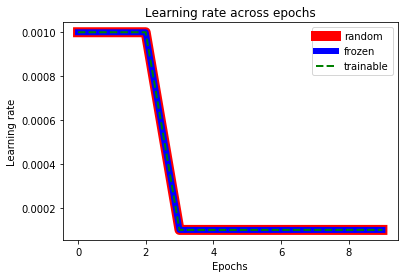

In [32]:
# Learning rate across epochs
plt.plot(range(0, len(lr_all[0])), lr_all[0], 'r', label = 'random', linewidth=10)
plt.plot(range(0, len(lr_all[1])), lr_all[1], 'b', label = 'frozen', linewidth=6)
plt.plot(range(0, len(lr_all[2])), lr_all[2], 'g--', label = 'trainable', linewidth=2)
plt.legend()
plt.title('Learning rate across epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')

Text(0, 0.5, 'Crossentropy Loss on test')

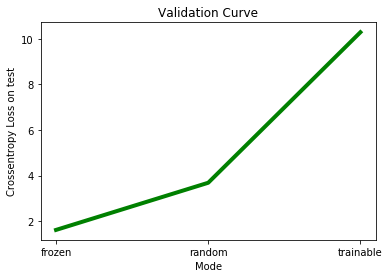

In [39]:
# Validation curve
plt.plot(['frozen', 'random', 'trainable'], [losses[1], losses[0], losses[2]], 'g', linewidth=4)
plt.title('Validation Curve')
plt.xlabel('Mode')
plt.ylabel('Crossentropy Loss on test')

Сохраним

In [8]:
with open('losses.pkl', 'wb') as file:
    pickle.dump(losses, file)

with open('lr_all.pkl', 'wb') as file:
    pickle.dump(lr_all, file)